# optimizationBasedDispatchModel
- @param `df_locations` : pd.Dataframe型の地理情報データ
- @param `df_bikes` : pd.Dataframe型の自転車データ
- @return `optimizationBasedDispatchModel`

## solve()
- @param `df_requests` : pd.Dataframe型のユーザーリクエスト
- @return `results` : 自転車IDと割り当てられたユーザーのキューインデックスのタプル型の集合をlist型として結果を出力

In [ ]:
# ライブラリのインストール
!pip install ortools

# デバッグ用
!pip install ipdb

In [ ]:
import branca.colormap as cm
import folium
import ipdb #デバッグ用
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from geopy.distance import geodesic
from ortools.linear_solver import pywraplp
from pandas import DataFrame

In [ ]:
# データの準備

'''locationID検索用CSV'''
df_locations = pd.read_csv('/content/taxi_zone_lookup_with_coordinates.csv')
# df_locations.set_index("LocationID", inplace=True)
print(df_locations.head())

   LocationID        Borough                     Zone service_zone   Latitude  \
0           1            EWR           Newark Airport          EWR  40.689531   
1           2         Queens              Jamaica Bay    Boro Zone  40.603994   
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone  40.865229   
3           4      Manhattan            Alphabet City  Yellow Zone  40.725102   
4           5  Staten Island            Arden Heights    Boro Zone  40.563700   

   Longitude  
0 -74.174462  
1 -73.835412  
2 -73.842739  
3 -73.979583  
4 -74.191603  


In [ ]:
'''自転車の集合'''
# ランダムシードを設定して、ランダムに10個選択
np.random.seed(42)
random_sample = df_locations.sample(n=10)

# Bike IDを設定
random_sample['Bike ID'] = range(10)

# 緯度と経度をホームポジションとカレントポジションに設定
random_sample['Home Position'] = list(zip(random_sample['Latitude'], random_sample['Longitude']))
random_sample['Current Location'] = random_sample['Home Position']

# 結果のデータフレームを整形
B = random_sample[['Bike ID', 'Home Position', 'Current Location']]
B.set_index("Bike ID", inplace=True)

# DODatetimeカラムを追加して初期値をNaTに設定
B['DODatetime'] = pd.NaT

# データの中身を確認
B

<ipython-input-72-dda8664dd68f>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  B['DODatetime'] = pd.NaT


,Home Position,Current Location,DODatetime
Bike ID,,,
0,"(40.67677, -73.8437461)","(40.67677, -73.8437461)",NaT
1,"(40.8241451, -73.9500618)","(40.8241451, -73.9500618)",NaT
2,"(40.6907711, -73.9766245)","(40.6907711, -73.9766245)",NaT
3,"(40.68562615, -73.98417065807277)","(40.68562615, -73.98417065807277)",NaT
4,"(40.67592055, -73.78496487588887)","(40.67592055, -73.78496487588887)",NaT
5,"(40.76883397436158, -73.95193997045698)","(40.76883397436158, -73.95193997045698)",NaT
6,"(40.70533183168504, -73.95019177498656)","(40.70533183168504, -73.95019177498656)",NaT
7,"(40.8473226, -73.7865218)","(40.8473226, -73.7865218)",NaT
8,"(40.750201, -73.993104)","(40.750201, -73.993104)",NaT


In [ ]:
'''ユーザーリクエストの集合'''

STARTING_DATE = '2023-01-01 0:00'
END_DATE = '2023-01-02 0:00'

# ParquetファイルのURL
url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet'

# Parquetファイルを読み込む
df = pd.read_parquet(url)

# 指定されたカラムのみを含むデータフレームを取得
df_requests = df[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID', 'DOLocationID']]

# データのフィルタリング
# 2023年1月1日以前のデータを削除
df_requests = df_requests[df_requests['tpep_pickup_datetime'] >= STARTING_DATE]
# 2023年2月1日以降のデータを削除
df_requests = df_requests[df_requests['tpep_pickup_datetime'] < END_DATE]

# ピックアップタイムの昇順で並び替え
df_requests = df_requests.sort_values(by='tpep_pickup_datetime')

# インデックスをリセット
df_requests = df_requests.reset_index(drop=True)

# フィルタリングされたデータの先頭を表示
print(df_requests.head())

# データフレームの情報を表示
print(df_requests.info())

  tpep_pickup_datetime tpep_dropoff_datetime  PULocationID  DOLocationID
0  2023-01-01 00:00:00   2023-01-01 00:08:00            42            41
1  2023-01-01 00:00:05   2023-01-01 00:26:27           249           186
2  2023-01-01 00:00:06   2023-01-01 00:05:44           125            68
3  2023-01-01 00:00:08   2023-01-01 00:11:24            42           244
4  2023-01-01 00:00:09   2023-01-01 00:15:10            79           231
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76752 entries, 0 to 76751
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tpep_pickup_datetime   76752 non-null  datetime64[us]
 1   tpep_dropoff_datetime  76752 non-null  datetime64[us]
 2   PULocationID           76752 non-null  int64         
 3   DOLocationID           76752 non-null  int64         
dtypes: datetime64[us](2), int64(2)
memory usage: 2.3 MB
None


In [ ]:
# optimizationBasedDispatchModelクラスを定義
class optimizationBasedDispatchModel():
  def __init__(self, df_locations, df_bikes):
    self.df_locations = df_locations
    self.df_bikes = df_bikes


  '''LocationIDから経度と緯度をタプルで返す関数'''
  def _get_coordinates_by_location_id(self, location_id):
    row = self.df_locations[self.df_locations['LocationID'] == location_id]
    if not row.empty:
        latitude = row.iloc[0]['Latitude']
        longitude = row.iloc[0]['Longitude']
        # 緯度と経度が有効な数値であるかどうかを確認する
        if pd.notna(latitude) and pd.notna(longitude):
            return (latitude, longitude)
        else:
            return None
    else:
        return None


  '''ユーザーリクエストJに対して移動後の自転車Bの位置関係を表す距離行列を返す関数'''
  def _generate_after_trip_distances(
      self,
      df_requests: DataFrame,
  ) -> np.ndarray:

      # 自転車とリクエストの数
      num_bikes = len(self.df_bikes)
      num_requests = len(df_requests)

      # 移動後の距離行列 d を作成 (d[b, j] が利用者 j が移動した後の自転車 b とその定位置までの距離)
      # 距離行列を初期化
      after_trip_distances = np.zeros((num_bikes, num_requests))
      for b in range(num_bikes):
          home_position = self.df_bikes.iloc[b].loc['Home Position']
          for j in range(num_requests):
              # df_requestsのj行目のDOLocationIDを取得する
              request_destination_id = df_requests.iloc[j].loc['DOLocationID']
              request_destination = self._get_coordinates_by_location_id(request_destination_id)
              # print("リクエストされたユーザーの目的地 位置座標:", request_destination)
              after_trip_distances[b, j] = geodesic(
                  home_position, request_destination
              ).m  # 単位はメートル

      # print('-----after_trip_distances-----')
      # print(after_trip_distances)
      return after_trip_distances


  '''ユーザーリクエストJに対して移動前の自転車Bの位置関係を表す距離行列を返す関数'''
  def _generate_before_trip_distances(
      self,
      df_requests: DataFrame,
  ) -> np.ndarray:

      # 自転車とリクエストの数
      num_bikes = len(self.df_bikes)
      num_requests = len(df_requests)

      # 移動前の距離行列 d を作成 (d[b, j] が利用者 j のリクエスト地点と自転車 b の現在地との距離)
      # 距離行列を初期化
      before_trip_distances = np.zeros((num_bikes, num_requests))
      for b in range(num_bikes):
          current_location = self.df_bikes.iloc[b].loc['Current Location']
          for j in range(num_requests):
              # df_requestsのj行目のPULocationIDを取得する
              request_pickup_id = df_requests.iloc[j].loc['PULocationID']
              request_pickup = self._get_coordinates_by_location_id(request_pickup_id)
              # print("リクエストされたユーザーの位置座標:", request_pickup)
              before_trip_distances[b, j] = geodesic(
                  current_location, request_pickup
              ).m  # 単位はメートル

      # print('-----before_trip_distances-----')
      # print(before_trip_distances)
      return before_trip_distances


  '''利用可能な自転車の集合を返す関数'''
  def _get_available_bikes(
      self,
      current_time: datetime = None
  ) -> np.ndarray:
      # current_timeがNoneの場合、現在時刻を取得
      # 本番運用時はcurrent_timeを利用しない
      if current_time is None:
          current_time = datetime.now()

      # 利用可能な自転車を1、不可能な自転車を0とする行列を作成
      available_bikes = (B['DODatetime'].isna() | (B['DODatetime'] < current_time)).astype(int)
      # available_bikes = ((self.df_bikes['DODatetime'] == pd.NaT) | (self.df_bikes['DODatetime'] < current_time)).astype(int)
      # print('-----available_bikes.values-----')
      # print(available_bikes.values)
      return available_bikes.values


  '''割り当て成功後の自転車ステータスの更新'''
  def _update_bike_status(
      self,
      bike_assignment,
      df_requests
  ):
      for b, j in bike_assignment:
          # jのtpep_dropoff_datetimeを取得するし自転車ステータス更新する
          # df_requestsのインデックスjに対応する行を取得
          request_row = df_requests.iloc[j]
          self.df_bikes.at[b, 'DODatetime'] = request_row['tpep_dropoff_datetime']
          # jのDOLocationIDを取得して自転車のCurrent Locationを更新する
          self.df_bikes.at[b, 'Current Location'] = self._get_coordinates_by_location_id(request_row['DOLocationID'])


  '''結果出力用メソッド'''
  def _print_results(self, result_dict):
      # 辞書型のそれぞれのデータに対して"key: value"形式で出力する
      for key, value in result_dict.items():
          print(f"{key}: {value}")
      # print("-------------------------------------------------------")

  '''最適化メイン処理'''
  def solve(self, df_requests):
    # ipdb.set_trace()  # ブレークポイントを設定
    # ユーザーリクエストJに対して移動された自転車Bにおける、自転車の定位置との距離行列
    distances = self._generate_after_trip_distances(df_requests)
    # ユーザーリクエストJに対してマッチングする前の自転車との距離行列
    initial_distances = self._generate_before_trip_distances(df_requests)

    # 利用可能な自転車を取得する
    # df_requestsの最終行のtpep_pickup_datetimeカラムの値を取得する
    current_time = df_requests.iloc[-1]['tpep_pickup_datetime']
    # print('-----current_time-----')
    # print(current_time)
    available_bikes = self._get_available_bikes(current_time)

    # 問題の正規化
    average = distances.mean()
    std = distances.std()
    distances: np.ndarray = (distances - average) / std


    # OR-Toolsのソルバーを作成
    solver = pywraplp.Solver.CreateSolver('SCIP')

    # 変数の定義
    x = []
    for b in range(self.df_bikes.shape[0]):
        x.append([])
        for j in range(df_requests.shape[0]):
            x[b].append(solver.BoolVar(f'x[{b},{j}]'))

    alpha = 1.0

    # 目的関数の定義
    # 第一項: ユーザーの移動後の自転車の現在地と定位置との距離を短くする
    distance_objective = solver.Sum(distances[b][j] * x[b][j] for b in range(self.df_bikes.shape[0]) for j in range(df_requests.shape[0]))
    # 第二項: より多くのユーザーに自転車を割り当てる
    sum_x = solver.Sum(x[b][j] for b in range(self.df_bikes.shape[0]) for j in range(df_requests.shape[0]))

    objective = distance_objective - alpha * sum_x
    solver.Minimize(objective)

    # 制約条件の定義

    # 各ユーザーは1台の自転車にしか割り当てられない
    for b in range(self.df_bikes.shape[0]):
        solver.Add(solver.Sum(x[b][j] for j in range(df_requests.shape[0])) <= 1)

    # 各自転車は１人のユーザーにしか割り当てられない
    for j in range(df_requests.shape[0]):
        solver.Add(solver.Sum(x[b][j] for b in range(self.df_bikes.shape[0])) <= 1)

    # 徒歩30分で移動できる距離
    R = 2500
    # 半径r内に存在する自転車しかユーザーに割り当てない制約
    for b in range(self.df_bikes.shape[0]):
        for j in range(df_requests.shape[0]):
            if initial_distances[b][j] > R:
                solver.Add(x[b][j] == 0)

    # 他ユーザーに割り当てられていない利用可能な自転車のみを割り当てる
    for b in range(available_bikes.shape[0]):
        if available_bikes[b] == 0:
            for j in range(df_requests.shape[0]):
                solver.Add(x[b][j] == 0)

    # ipdb.set_trace()  # ブレークポイントを設定
    # ソルバーを実行
    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        # print('解が見つかりました:')
        bike_assignment = []
        for b in range(B.shape[0]):
            for j in range(J.shape[0]):
                if x[b][j].solution_value() == 1:
                    bike_assignment.append((b, j))
                    # print(f"利用者 {j}: 自転車 {b}")
        self._update_bike_status(bike_assignment, df_requests)
        # _print_results()に結果を渡して出力する
        result_dict = {
            "Distance objective": distance_objective.solution_value(),
            "Sum of assignments": sum_x.solution_value(),
            "Objective value": objective.solution_value(),
            "bike_assignment": bike_assignment,
        }
        self._print_results(result_dict) #←モデル検証・デバッグ用
        return bike_assignment #←モデル検証・デバッグ時はコメントアウトする。実際にはこれを返す。
    else:
        raise RuntimeError("No feasible solution was found.")


# 動作確認

In [ ]:
# optimizationBasedDispatchModelの初期化・インスタンス作成
optimizationBasedDispatchModel = optimizationBasedDispatchModel(df_locations, B)

In [ ]:
# モデリングするためにユーザーリクエストデータを整形する

# tpep_pickup_datetimeをdatetime型に変換
df_requests['tpep_pickup_datetime'] = pd.to_datetime(df_requests['tpep_pickup_datetime'])
df_requests['tpep_dropoff_datetime'] = pd.to_datetime(df_requests['tpep_dropoff_datetime'])

# リクエストデータを一分ごとに分割
start_time = df_requests['tpep_pickup_datetime'].min()
end_time = df_requests['tpep_pickup_datetime'].max()
print(f"リクエストの開始時間：{start_time}")
print(f"リクエストの終了時間：{end_time}")

# マッチングプロセスのログデータ収集用時系列データ
time_series_log_data = []

# データを1分ごとに処理
current_time = start_time
while current_time < end_time:
    print(f"Time: {current_time}")
    next_time = current_time + pd.Timedelta(minutes=1)
    # 現在の1分間のリクエストを抽出
    J = df_requests[(df_requests['tpep_pickup_datetime'] >= current_time) & (df_requests['tpep_pickup_datetime'] < next_time)]
    # print(J)
    if not J.empty:
        # solve()を実行
        # print(J)
        # if current_time == datetime.strptime('2023-01-01 00:03:00', '%Y-%m-%d %H:%M:%S'):
        #     # テスト用に3分間で停止する。
        #     break

        # 自転車占有率を計算する
        available_bikes = optimizationBasedDispatchModel._get_available_bikes(current_time)
        bikes_occupied_rate = 1 - available_bikes.sum() / len(available_bikes)
        print(f"Bikes Occupied Rate: {bikes_occupied_rate}")

        #本番用
        try:
            bike_assignment = optimizationBasedDispatchModel.solve(J)
            # print(f"Time: {current_time}, Assignments: {bike_assignment}")
        except RuntimeError:
            bike_assignment = []
            print("No feasible solution was found.")
            print("-------------------------------------------------------")

        # テスト用
        # print(f"Time: {current_time}")
        # optimizationBasedDispatchModel.solve(J)

        # マッチング成功率を計算する
        matching_success_rate = len(bike_assignment) / len(J)
        print(f"Matching Success Rate: {matching_success_rate}")
        print("-------------------------------------------------------")

        # ログ出力
        time_series_log_data.append({
            'time': current_time,
            'matching_success_rate': matching_success_rate,
            'bikes_occupied_rate': bikes_occupied_rate
        })

    # 次の1分へ移動
    current_time = next_time


Streaming output truncated to the last 5000 lines.
Time: 2023-01-01 13:35:00
Bikes Occupied Rate: 0.7
Distance objective: -0.33871515745435454
Sum of assignments: 2.0
Objective value: -2.3387151574543545
bike_assignment: [(1, 75), (5, 26)]
Matching Success Rate: 0.02631578947368421
-------------------------------------------------------
Time: 2023-01-01 13:36:00
Bikes Occupied Rate: 0.7
Distance objective: 0.0
Sum of assignments: 0.0
Objective value: 0.0
bike_assignment: []
Matching Success Rate: 0.0
-------------------------------------------------------
Time: 2023-01-01 13:37:00
Bikes Occupied Rate: 0.7
Distance objective: 0.0
Sum of assignments: 0.0
Objective value: 0.0
bike_assignment: []
Matching Success Rate: 0.0
-------------------------------------------------------
Time: 2023-01-01 13:38:00
Bikes Occupied Rate: 0.7
Distance objective: 0.0
Sum of assignments: 0.0
Objective value: 0.0
bike_assignment: []
Matching Success Rate: 0.0
------------------------------------------------

In [ ]:
# 自転車のステータスを確認
B

,Home Position,Current Location,DODatetime
Bike ID,,,
0,"(40.67677, -73.8437461)","(40.659097, -73.95468)",2023-01-01 23:29:33
1,"(40.8241451, -73.9500618)","(40.908178, -73.905353)",2023-01-01 18:18:53
2,"(40.6907711, -73.9766245)","(40.689531, -74.174462)",2023-01-01 21:05:28
3,"(40.68562615, -73.98417065807277)","(40.6897222, -73.9652778)",2023-01-01 23:39:19
4,"(40.67592055, -73.78496487588887)","(40.6212155, -73.9348597)",2023-01-01 17:08:05
5,"(40.76883397436158, -73.95193997045698)","(40.76883397436158, -73.95193997045698)",2023-01-02 14:06:42
6,"(40.70533183168504, -73.95019177498656)","(40.665306, -73.9124755)",2023-01-01 23:38:55
7,"(40.8473226, -73.7865218)","(40.8473226, -73.7865218)",NaT
8,"(40.750201, -73.993104)","(40.750201, -73.993104)",2023-01-02 16:09:07


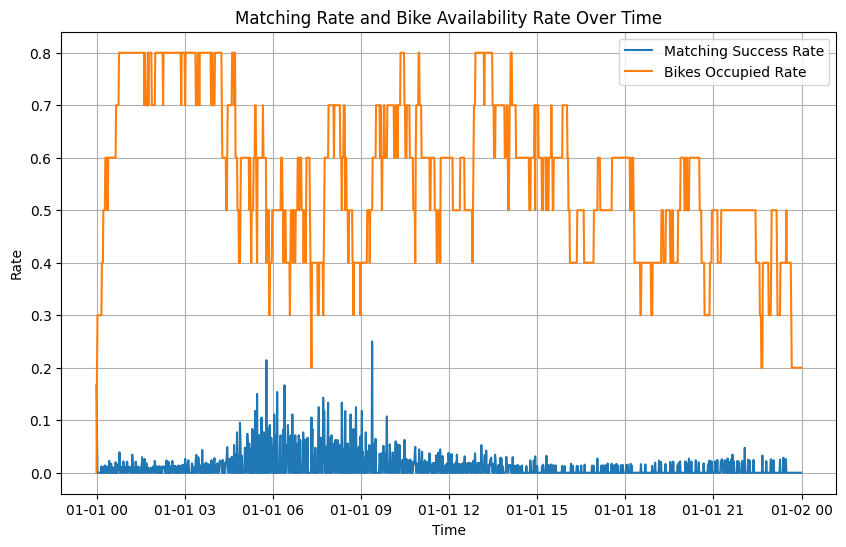

In [ ]:
# 自転車の割り当て成功率と占有率との関係をグラフ化する

# ログデータをデータフレームにコンバートする
df_time_series = pd.DataFrame(time_series_log_data)

# プロット
plt.figure(figsize=(10, 6))

plt.plot(df_time_series['time'], df_time_series['matching_success_rate'], label='Matching Success Rate')
plt.plot(df_time_series['time'], df_time_series['bikes_occupied_rate'], label='Bikes Occupied Rate')

plt.xlabel('Time')
plt.ylabel('Rate')
plt.title('Matching Rate and Bike Availability Rate Over Time')
plt.legend()
plt.grid(True)

plt.show()

# 最終自転車分布

In [ ]:
'''ユーザーの位置と自転車の位置をプロットする関数'''
def plot_users_and_bikes(
    user_locations: np.ndarray,
    bike_locations: np.ndarray,
    latitude_range: tuple[float, float],  # 描画範囲 (緯度)
    longitude_range: tuple[float, float],  # 描画範囲 (経度)
):
    m = folium.Map(
        [sum(latitude_range) / 2, sum(longitude_range) / 2],
        tiles="OpenStreetMap",
        zoom_start=11,
    )

    for latitude, longitude in user_locations:
        folium.Marker(
            location=(latitude, longitude),
            icon=folium.Icon(icon="user", prefix="fa", color="orange"),
        ).add_to(m)

    for latitude, longitude in bike_locations:
        folium.Marker(
            location=(latitude, longitude),
            icon=folium.Icon(icon="bicycle", prefix="fa", color="green"),
        ).add_to(m)

    return m

In [ ]:
# latitudeカラムとlongitudeカラムの最大値と最小値を取得
latitude_max = df_locations['Latitude'].max()
latitude_min = df_locations['Latitude'].min()
longitude_max = df_locations['Longitude'].max()
longitude_min = df_locations['Longitude'].min()

# 結果を表示
print(f"Latitude: max = {latitude_max}, min = {latitude_min}")
print(f"Longitude: max = {longitude_max}, min = {longitude_min}")

Latitude: max = 40.908178, min = 40.52825085411132
Longitude: max = -73.7115199, min = -74.23462644152289


In [ ]:
# NYC
latitude_range = (latitude_min - 0.1, latitude_max + 0.1)
longitude_range = (longitude_min - 0.1, longitude_max + 0.1)
print(latitude_range)
print(longitude_range)

current_locations = B['Current Location'].values
print(type(current_locations))
print(current_locations)

(40.42825085411132, 41.008178)
(-74.33462644152289, -73.6115199)
<class 'numpy.ndarray'>
[(40.659097, -73.95468) (40.908178, -73.905353) (40.689531, -74.174462)
 (40.6897222, -73.9652778) (40.6212155, -73.9348597)
 (40.76883397436158, -73.95193997045698) (40.665306, -73.9124755)
 (40.8473226, -73.7865218) (40.750201, -73.993104) (40.823144, -73.81076)]


In [ ]:
plot_users_and_bikes([], current_locations, latitude_range, longitude_range)